In [6]:
!pip install "numpy<2"
!pip install scikit-learn-extra


In [7]:
from google.colab import files
import pandas as pd

#
uploaded = files.upload()


Saving Taiwan dataset.csv to Taiwan dataset (1).csv


In [8]:
df = pd.read_csv("Taiwan dataset.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



[INFO] XGBoost - Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.2}
[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3696
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

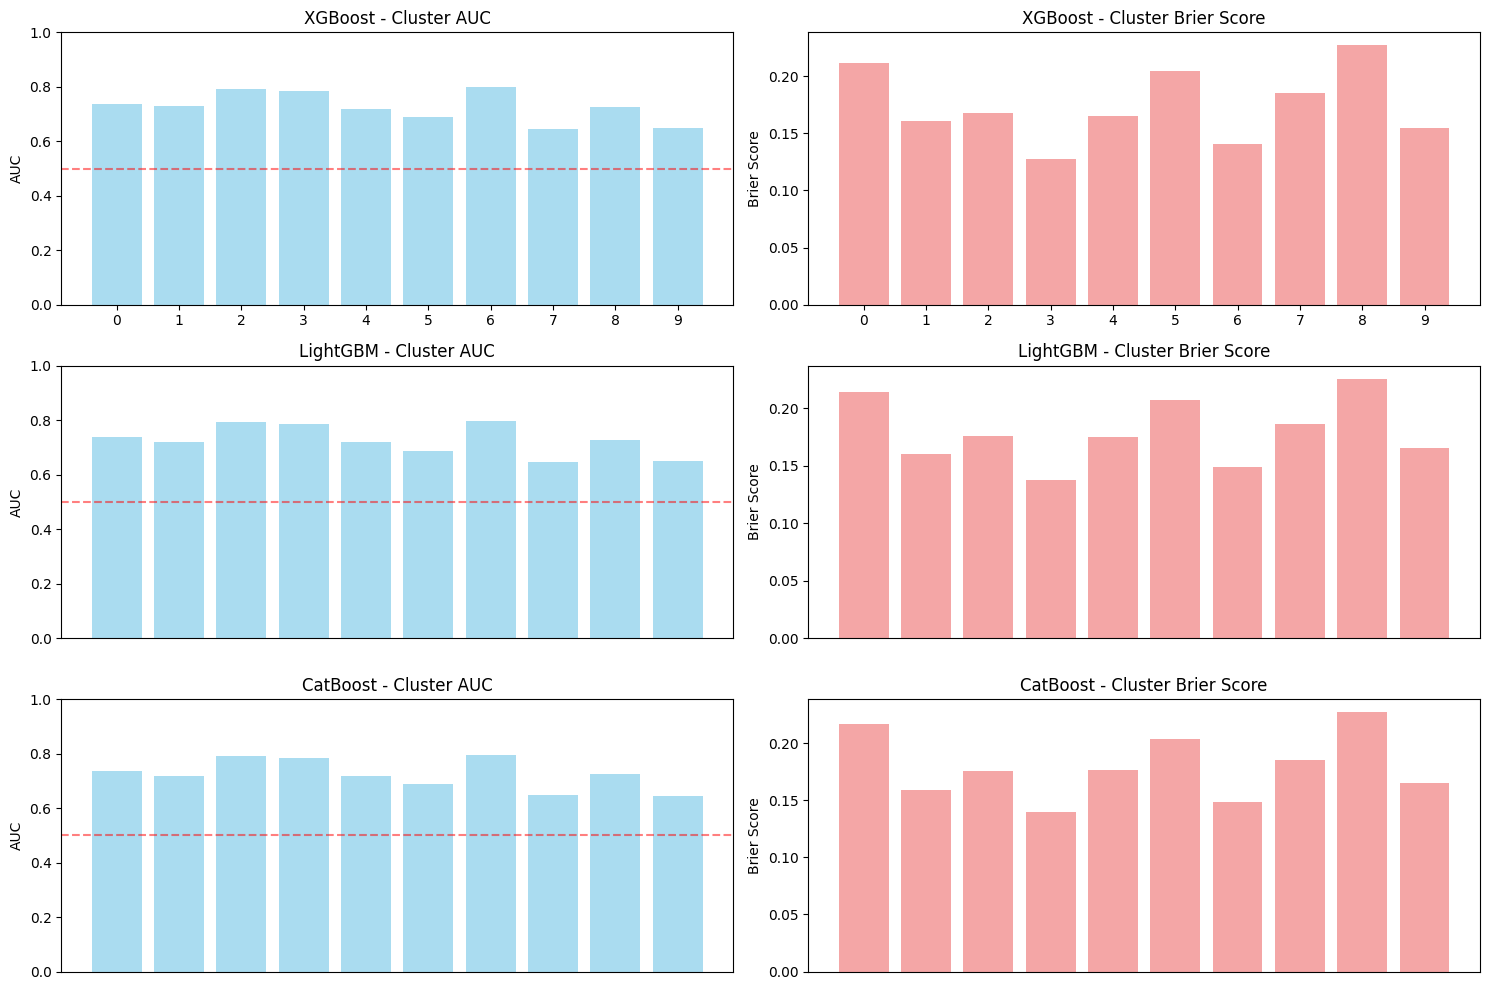

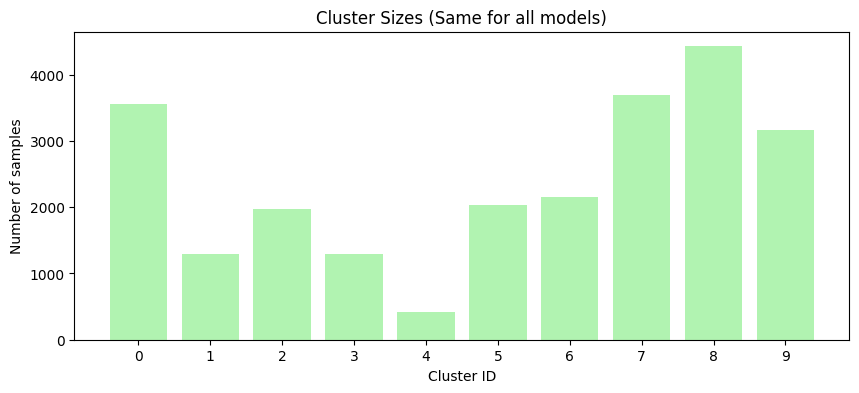


=== Analisi Cluster con profili medi e performance (XGBoost) ===
   Cluster  Size       AUC     Brier            ID      LIMIT_BAL       SEX  \
7        7  3698  0.646805  0.185074  15163.108167  204745.808545  1.684694   
9        9  3163  0.649517  0.154274  15125.061650  387935.504268  1.599431   
5        5  2032  0.689734  0.204589  14834.003445  105831.692913  1.713583   
4        4   414  0.717364  0.165465  15555.038647  169685.990338  1.541063   
8        8  4426  0.725642  0.227101  14475.453683   31288.296430  1.512878   
1        1  1292  0.728431  0.160495  15881.067337  345441.176471  1.561146   
0        0  3554  0.737936  0.211908  14722.210186   61646.032639  1.581598   
3        3  1297  0.783203  0.127265  15159.212028  214148.033924  1.659214   
2        2  1978  0.793478  0.167721  15082.080384  111698.685541  1.615268   
6        6  2146  0.800667  0.140556  15129.958993  207218.080149  1.595527   

   EDUCATION  MARRIAGE        AGE     PAY_1     PAY_2     PAY_3 

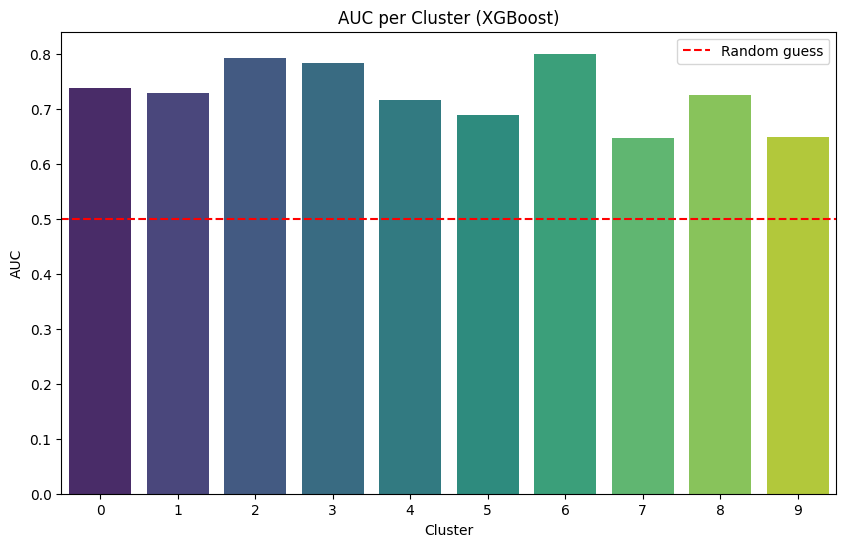

In [10]:
# ==========================
# IMPORT LIBRERIE
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Gradient boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Clustering
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import pdist, squareform

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.ensemble import RandomForestRegressor

# Rename columns
df = df.rename(columns={'default.payment.next.month': 'def_pay', 'PAY_0': 'PAY_1'})

# Clean strange values
df.loc[(df.EDUCATION.isin([0, 5, 6])), 'EDUCATION'] = 4
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

# Separate X  y
X = df.drop('def_pay', axis=1)
y = df['def_pay']

# Split train-test 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# ==========================
# TRAIN + RANDOMIZEDSEARCHCV
# ==========================
def train_model_cv_holdout_with_train_report(params, Model, X_train, X_test, y_train, y_test, model_name):
    from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
    from imblearn.pipeline import make_pipeline
    from imblearn.over_sampling import SMOTE
    from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss

    # find iperparameters
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rand_search = RandomizedSearchCV(
        estimator=Model,
        param_distributions=params,
        n_iter=4,
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1,
        random_state=42
    )

    pipeline_search = make_pipeline(
        SMOTE(sampling_strategy='minority', random_state=42),
        rand_search
    )
    pipeline_search.fit(X_train, y_train)
    best_params = rand_search.best_params_
    print(f"\n[INFO] {model_name} - Best Params:", best_params)

    # Modello finale
    best_model = Model.set_params(**best_params)
    pipeline_final = make_pipeline(
        SMOTE(sampling_strategy='minority', random_state=42),
        best_model
    )
    pipeline_final.fit(X_train, y_train)

    # Probability prediction
    y_pred_proba_train = pipeline_final.predict_proba(X_train)[:, 1]
    y_pred_proba_test = pipeline_final.predict_proba(X_test)[:, 1]

    results = {
        'Algorithm': model_name,
        'AUC Train': round(roc_auc_score(y_train, y_pred_proba_train), 3),
        'AUC Test': round(roc_auc_score(y_test, y_pred_proba_test), 3),
        'Brier Train': round(brier_score_loss(y_train, y_pred_proba_train), 3),
        'Brier Test': round(brier_score_loss(y_test, y_pred_proba_test), 3),
        'LogLoss Train': round(log_loss(y_train, y_pred_proba_train), 3),
        'LogLoss Test': round(log_loss(y_test, y_pred_proba_test), 3),
    }

    return results, best_params, pipeline_final


# ==========================
# Training three models
# ==========================

Models = pd.DataFrame(
    columns=['Algorithm', 'AUC Train', 'AUC Test', 'Brier Train', 'Brier Test', 'LogLoss Train', 'LogLoss Test'])

# --- XGBoost ---
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [1],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}
xgb_result, xgb_best_params, pipeline_xgb_final = train_model_cv_holdout_with_train_report(
    xgb_params, XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    X_train, X_test, y_train, y_test, "XGBoost"
)
Models = pd.concat([Models, pd.DataFrame([xgb_result])], ignore_index=True)

# --- LightGBM ---
lgbm_params = {'n_estimators': [100], 'max_depth': [1], 'learning_rate': [0.1], 'subsample': [1.0]}
lgbm_result, lgbm_best_params, pipeline_lgbm_final = train_model_cv_holdout_with_train_report(
    lgbm_params, LGBMClassifier(random_state=42),
    X_train, X_test, y_train, y_test, "LightGBM"
)
Models = pd.concat([Models, pd.DataFrame([lgbm_result])], ignore_index=True)

# --- CatBoost ---
cat_params = {'depth': [1], 'iterations': [100], 'learning_rate': [0.1]}
cat_result, cat_best_params, pipeline_cat_final = train_model_cv_holdout_with_train_report(
    cat_params, CatBoostClassifier(verbose=0, random_state=42),
    X_train, X_test, y_train, y_test, "CatBoost"
)
Models = pd.concat([Models, pd.DataFrame([cat_result])], ignore_index=True)

print("\n=== Final Results ===")
print(Models)


# ==========================
# CLUSTER + METRICS
# =====
# ==========================
# CLUSTERING AND ANALYSYS FOR CLUSTERS
# ==========================
# ==========================
# EFFICIENT CLUSTERING AS IN THE PAPER
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, brier_score_loss


def create_clusters_efficient(X, n_clusters=10, sample_size=5000, random_state=42):
    """
    Efficiently create clusters as in the paper:
    1. Sample a subset to find the centroids
    2. Assign all points to the nearest clusters
"""
    # 1. Sample from a dataset
    np.random.seed(random_state)
    sample_idx = np.random.choice(len(X), min(sample_size, len(X)), replace=False)
    X_sample = X[sample_idx]

    # 2. Clustering on the sample
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=random_state)
    kmedoids.fit(X_sample)

    # 3. find centroids
    centroids = kmedoids.cluster_centers_

    # 4. tag each point
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(centroids)
    _, all_clusters = nn.kneighbors(X)

    return all_clusters.flatten()


def calculate_cluster_metrics(model, X, y, clusters):
    """
    Calculate AUC  Brier score
    """
    unique_clusters = np.unique(clusters)
    results = []

    for cluster_id in unique_clusters:
        cluster_mask = (clusters == cluster_id)
        X_cluster = X[cluster_mask]
        y_cluster = y[cluster_mask]

        if len(np.unique(y_cluster)) < 2:
            # Skip cluster with one class
            auc_score = np.nan
            brier_score = np.nan
        else:
            # forecast for each cluster
            y_pred_proba = model.predict_proba(X_cluster)[:, 1]

            # Metrics calculation
            auc_score = roc_auc_score(y_cluster, y_pred_proba)
            brier_score = brier_score_loss(y_cluster, y_pred_proba)

        results.append({
            'Cluster': cluster_id,
            'Size': np.sum(cluster_mask),
            'AUC': auc_score,
            'Brier': brier_score
        })

    return pd.DataFrame(results)


# ==========================
# Model application
# ==========================
# Clustering parameters
n_clusters = 10
sample_size = 5000  # as in the paper

# Create cluster
print("Creation cluster on going...")
train_clusters = create_clusters_efficient(
    X_train.values,
    n_clusters=n_clusters,
    sample_size=sample_size
)

# Calculate metrics for each cluster and for each model
print("Calculation for each cluster...")
cluster_results = {}

# XGBoost
xgb_cluster_metrics = calculate_cluster_metrics(
    pipeline_xgb_final.named_steps['xgbclassifier'],  # Nome corretto
    X_train.values, y_train.values, train_clusters
)
cluster_results['XGBoost'] = xgb_cluster_metrics

# LightGBM
lgbm_cluster_metrics = calculate_cluster_metrics(
    pipeline_lgbm_final.named_steps['lgbmclassifier'],
    X_train.values, y_train.values, train_clusters
)
cluster_results['LightGBM'] = lgbm_cluster_metrics

# CatBoost
cat_cluster_metrics = calculate_cluster_metrics(
    pipeline_cat_final.named_steps['catboostclassifier'],
    X_train.values, y_train.values, train_clusters
)
cluster_results['CatBoost'] = cat_cluster_metrics


# ==========================
# VISUALIZATION AS IN THE PAPER
# ==========================
def plot_cluster_performance(cluster_results, figsize=(15, 10)):
    """
    Create plot as figure 1 and 2 in the paper
    """
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    models = list(cluster_results.keys())

    for i, model_name in enumerate(models):
        df = cluster_results[model_name]

        # Plot AUC per cluster
        axes[i, 0].bar(df['Cluster'], df['AUC'], color='skyblue', alpha=0.7)
        axes[i, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        axes[i, 0].set_title(f'{model_name} - Cluster AUC')
        axes[i, 0].set_ylabel('AUC')
        axes[i, 0].set_ylim(0, 1)

        # Plot Brier score per cluster
        axes[i, 1].bar(df['Cluster'], df['Brier'], color='lightcoral', alpha=0.7)
        axes[i, 1].set_title(f'{model_name} - Cluster Brier Score')
        axes[i, 1].set_ylabel('Brier Score')

        # Plot size cluster (stessa per tutti i modelli)
        if i == 0:  # Solo per il primo modello
            axes[i, 0].set_xticks(df['Cluster'])
            axes[i, 1].set_xticks(df['Cluster'])
        else:
            axes[i, 0].set_xticks([])
            axes[i, 1].set_xticks([])

    plt.tight_layout()
    plt.show()

    # Plot separated
    cluster_sizes = cluster_results['XGBoost']['Size'].values
    cluster_ids = cluster_results['XGBoost']['Cluster'].values

    plt.figure(figsize=(10, 4))
    plt.bar(cluster_ids, cluster_sizes, color='lightgreen', alpha=0.7)
    plt.title('Cluster Sizes (Same for all models)')
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of samples')
    plt.xticks(cluster_ids)
    plt.show()


# plot generation
print("Plot generation...")
plot_cluster_performance(cluster_results)

################################################
# Take the XGBoost model, look at how the clusters are formed: their economic meaning
# and see where the AUC performs better or worse

# ==========================
# CLUSTER PROFILES + PERFORMANCE ANALYSIS
# ==========================

# 1. Create a dataframe with features + cluster
cluster_profiles = pd.DataFrame(X_train, columns=X_train.columns)
cluster_profiles['Cluster'] = train_clusters

# 2. Calculate the avarage profiles for each variable in each cluster
cluster_summary = cluster_profiles.groupby('Cluster').mean().reset_index()

# 3. Take the performance metrics
cluster_analysis = xgb_cluster_metrics.merge(cluster_summary, on='Cluster')

# 4. sort the cluster by the AUC
cluster_analysis = cluster_analysis.sort_values('AUC', ascending=True)

# 5. Show the table
pd.set_option("display.max_columns", None)  # per vedere tutte le variabili
print("\n=== Analisi Cluster con profili medi e performance (XGBoost) ===")
print(cluster_analysis.head(10))  # mostra tutti e 10

# 6. AUC PLOT
plt.figure(figsize=(10,6))
sns.barplot(data=cluster_analysis, x='Cluster', y='AUC', palette='viridis')
plt.axhline(0.5, color='red', linestyle='--', label='Random guess')
plt.title('AUC per Cluster (XGBoost)')
plt.ylabel('AUC')
plt.xlabel('Cluster')
plt.legend()
plt.show()
